## Sparse Matrix Example

This notebook implements a SENSE Example with sparse interpolation matrices. Sparse matrix-based interpolation is usually slower than table-based interpolation, but can be a bit more accurate, or might be faster for certain problem structures.

### References

Fessler, J. A., & Sutton, B. P. (2003). Nonuniform fast Fourier transforms using min-max interpolation. IEEE transactions on signal processing, 51(2), 560-574.

Beatty, P. J., Nishimura, D. G., & Pauly, J. M. (2005). Rapid gridding reconstruction with a minimal oversampling ratio. IEEE transactions on medical imaging, 24(6), 799-808.

In [2]:
# make sure we have all required packages

!pip install torchkbnufft matplotlib numpy torch scikit-image

try:
    from mrisensesim import mrisensesim
except ModuleNotFoundError:
    !git clone https://github.com/mmuckley/torchkbnufft.git .tkbn_git
    !cp .tkbn_git/notebooks/mrisensesim.py .

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import time
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchkbnufft as tkbn
from skimage.data import shepp_logan_phantom

from mrisensesim import mrisensesim

filterwarnings("ignore") # ignore floor divide warnings
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

findfont: Font family ['migmix-1p-regular'] not found. Falling back to DejaVu Sans.
findfont: Font family ['migmix-1p-regular'] not found. Falling back to DejaVu Sans.


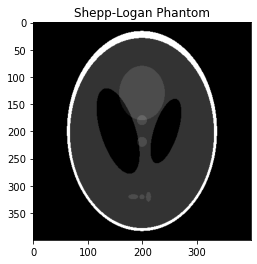

In [4]:
# create a simple shepp logan phantom and plot it
image = shepp_logan_phantom().astype(complex)
im_size = image.shape
plt.imshow(np.absolute(image))
plt.gray()
plt.title('Shepp-Logan Phantom')
plt.show()

In [5]:
# convert the phantom to a tensor and unsqueeze coil and batch dimension
image = torch.tensor(image, device=device).unsqueeze(0).unsqueeze(0)
print('image shape: {}'.format(image.shape))

image shape: torch.Size([1, 1, 400, 400])


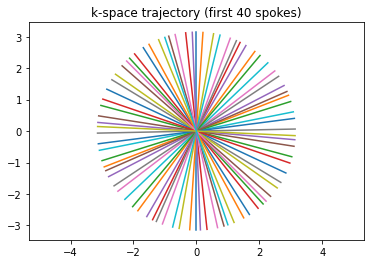

In [6]:
# create a k-space trajectory and plot it
spokelength = image.shape[-1] * 2
grid_size = (spokelength, spokelength)
nspokes = 405

ga = np.deg2rad(180 / ((1 + np.sqrt(5)) / 2))
kx = np.zeros(shape=(spokelength, nspokes))
ky = np.zeros(shape=(spokelength, nspokes))
ky[:, 0] = np.linspace(-np.pi, np.pi, spokelength)
for i in range(1, nspokes):
    kx[:, i] = np.cos(ga) * kx[:, i - 1] - np.sin(ga) * ky[:, i - 1]
    ky[:, i] = np.sin(ga) * kx[:, i - 1] + np.cos(ga) * ky[:, i - 1]
    
ky = np.transpose(ky)
kx = np.transpose(kx)

ktraj = np.stack((ky.flatten(), kx.flatten()), axis=0)

# plot the first 40 spokes
plt.plot(kx[:40, :].transpose(), ky[:40, :].transpose())
plt.axis('equal')
plt.title('k-space trajectory (first 40 spokes)')
plt.show()

In [7]:
# convert k-space trajectory to a tensor
ktraj = torch.tensor(ktraj, device=device)
print('ktraj shape: {}'.format(ktraj.shape))

ktraj shape: torch.Size([2, 324000])


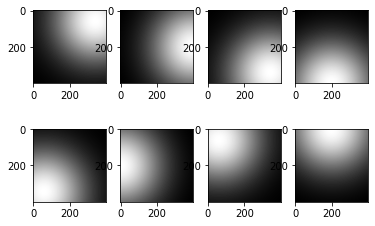

In [8]:
# simulate some sensitivity coils (no phase for simplicity)
ncoil = 8
smap = np.absolute(np.stack(mrisensesim(im_size, coil_width=64))).astype(complex)

fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flat):
    ax.imshow(np.absolute(smap[i]))
plt.gray()
    
plt.show()

In [9]:
# convert smaps to tensors, unsqueeze batch dimension
smap = torch.tensor(smap).unsqueeze(0).to(image)

In [10]:
# build nufft operators
nufft_ob = tkbn.KbNufft(im_size=im_size, grid_size=grid_size).to(image)
adjnufft_ob = tkbn.KbNufftAdjoint(im_size=im_size, grid_size=grid_size).to(image)

print(nufft_ob)
print(adjnufft_ob)


KbNufft
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (400, 400)


KbNufftAdjoint
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (400, 400)



In [11]:
interp_mats = tkbn.calc_tensor_spmatrix(
    ktraj,
    im_size,
)
interp_mats = tuple([t.to(torch.double) for t in interp_mats])

In [12]:
# calculate k-space data, run some time tests
start_normal = time.perf_counter()
kdata = nufft_ob(image, ktraj, smaps=smap)
end_normal = time.perf_counter()

start_spmat = time.perf_counter()
kdata = nufft_ob(image, ktraj, interp_mats=interp_mats, smaps=smap)
end_spmat = time.perf_counter()

# add some noise (robustness test)
siglevel = torch.abs(kdata).mean()
kdata = kdata + (siglevel/5) * torch.randn(kdata.shape).to(kdata)

# write the timings
# for forward problem, sparse matrices often don't help
print('normal interpolation time: {}'.format(end_normal-start_normal))
print('sparse matrix interpolation time: {}'.format(end_spmat-start_spmat))

normal interpolation time: 0.18104061900521629
sparse matrix interpolation time: 0.3912929790094495


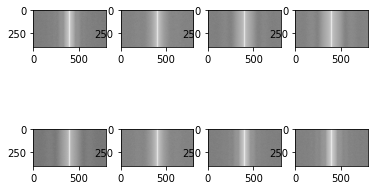

In [13]:
# convert kdata to numpy and plot
kdata_numpy = np.reshape(kdata.cpu().numpy(), (ncoil, nspokes, spokelength))

fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flat):
    ax.imshow(np.log10(np.absolute(kdata_numpy[i])))
plt.gray()
    
plt.show()

In [14]:
# adjnufft back
# method 1: no density compensation (blurry image)
# run timing tests here
start_normal = time.perf_counter()
image_blurry = adjnufft_ob(kdata, ktraj, smaps=smap)
end_normal = time.perf_counter()

start_spmat = time.perf_counter()
image_blurry = adjnufft_ob(kdata, ktraj, interp_mats=interp_mats, smaps=smap)
end_spmat = time.perf_counter()

# print the timings
# usually sparse matrices help here
print('normal interpolation time: {}'.format(end_normal-start_normal))
print('sparse matrix interpolation time: {}'.format(end_spmat-start_spmat))

normal interpolation time: 0.4165011660079472
sparse matrix interpolation time: 0.1599815800145734


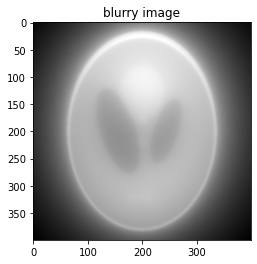

In [16]:
# show the images
image_blurry_numpy = np.squeeze(image_blurry.cpu().numpy())

#image_sharp_numpy = np.squeeze(image_sharp.cpu().numpy())

plt.figure(0)
plt.imshow(np.absolute(image_blurry_numpy))
plt.gray()
plt.title('blurry image')
"""
plt.figure(1)
plt.imshow(np.absolute(image_sharp_numpy))
plt.gray()
plt.title('sharp image (with Pipe dcomp)')
"""
plt.show()